In [1]:
import os
import re
import math
import copy
import pickle
import shutil
import warnings
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
import sys
sys.path.append("C:/Users/begas/Desktop/Project/Python/SmartFarm/5. SRC") # 다른 경로의 Class 불러올 때 사용
import common_preprocess_tools as prep
import pred_tools as pred

C:\Users\begas\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'

In [3]:
# -----------------------------------------------|
# ----- Step 1. Settings ------------------------
# -----------------------------------------------|
os.chdir("C:/Users/begas/Desktop/Project/Python/SmartFarm/")
os.getcwd()

home_path  = os.getcwd()
data_path  = os.path.join(home_path,"1. DAT")
save_path  = os.path.join(home_path,"2. OUT")
model_path = os.path.join(home_path,"3. MODEL")

os.makedirs(data_path,exist_ok=True)
os.makedirs(save_path,exist_ok=True)
os.makedirs(model_path,exist_ok=True)

data_files = os.path.join(data_path,os.listdir(data_path)[-1])
print(data_files)

working_date = '20220926'

C:\Users\begas\Desktop\Project\Python\SmartFarm\1. DAT\22_이엔티DB_이천분뇨자원화센터_내부.csv


### 데이터 불러오기

In [4]:
'''
data_files  : Raw 데이터 위치
time_grp    : 시간대별 통계량 요약 기준 단위(ex : if time_grp = 60, then 60분 단위로 통계량 요약)
timr_window : 시차 (예측시간으로부터 window_v시간 전의 데이터를 설명변수로 사용)
'''
_prep = prep.common_preprocess(data_files = data_files, time_grp = 60, time_window = [12,24])

In [5]:
_prep.load_fn()

>> Raw 데이터 호출 및 단일값 컬럼 제거
모든 값이 NA인 변수 제거 : 습도
모든 값이 단일값인 변수 제거 : 온도/환기팬


,시간,암모니아,황화수소
0,2022-01-15 14:31:00,2.8,0.1
1,2022-01-15 14:31:00,2.8,0.1
2,2022-01-15 14:31:00,2.8,0.1
3,2022-01-15 14:31:00,2.8,0.1
4,2022-01-15 14:31:00,2.8,0.1
...,...,...,...
448599,2022-08-29 14:26:00,21.5,0.1
448600,2022-08-29 14:26:00,22.0,0.1
448601,2022-08-29 14:26:00,18.2,0.1
448602,2022-08-29 14:26:00,20.2,0.1


### 예측 데이터 전처리 하기

>> 이상치, 결측치 처리 및 시간대별 요약 통계량 생성
Step1. 이상치를 허용범위 내로 보정
Step2. 시간 변수를 60 분 단위로 변경
Step3. 시간별 요약통계량 데이터 생성
Step4. 특정 시간대의 데이터가 비어있을 시 해당 시간대 생성
- 1547개의 시간대가 비어있습니다. 해당 시간대를 생성합니다.
Step5. 선형 보간법 적용
>> 암모니아_mean - 선형 보간법 적용
>> 황화수소_mean - 선형 보간법 적용
>> 암모니아_min - 선형 보간법 적용
>> 황화수소_min - 선형 보간법 적용
>> 암모니아_max - 선형 보간법 적용
>> 황화수소_max - 선형 보간법 적용
>> 암모니아_std - 선형 보간법 적용
>> 황화수소_std - 선형 보간법 적용


,시간,암모니아_mean,황화수소_mean,암모니아_min,황화수소_min,암모니아_max,황화수소_max,암모니아_std,황화수소_std
0,2022-01-15 14:00:00,2.807500,0.100833,2.8,0.1,3.7,0.2,8.215838e-02,9.128709e-03
1,2022-01-15 15:00:00,2.800000,0.100000,2.8,0.1,2.8,0.1,6.243317e-15,2.229756e-16
2,2022-01-15 16:00:00,2.800000,0.100000,2.8,0.1,2.8,0.1,6.243317e-15,2.229756e-16
3,2022-01-15 17:00:00,2.800000,0.100000,2.8,0.1,2.8,0.1,6.243317e-15,2.229756e-16
4,2022-01-15 18:00:00,2.800000,0.100000,2.8,0.1,2.8,0.1,5.356470e-15,1.952880e-16
...,...,...,...,...,...,...,...,...,...
5420,2022-08-29 10:00:00,14.592500,0.100000,2.8,0.1,24.2,0.1,3.653044e+00,2.229756e-16
5421,2022-08-29 11:00:00,20.642500,0.101667,2.8,0.1,39.3,0.2,6.325122e+00,1.285559e-02
5422,2022-08-29 12:00:00,13.365833,0.100000,2.8,0.1,27.3,0.1,3.978778e+00,2.229756e-16
5423,2022-08-29 13:00:00,14.245833,0.100000,2.8,0.1,25.1,0.1,3.277191e+00,2.229756e-16


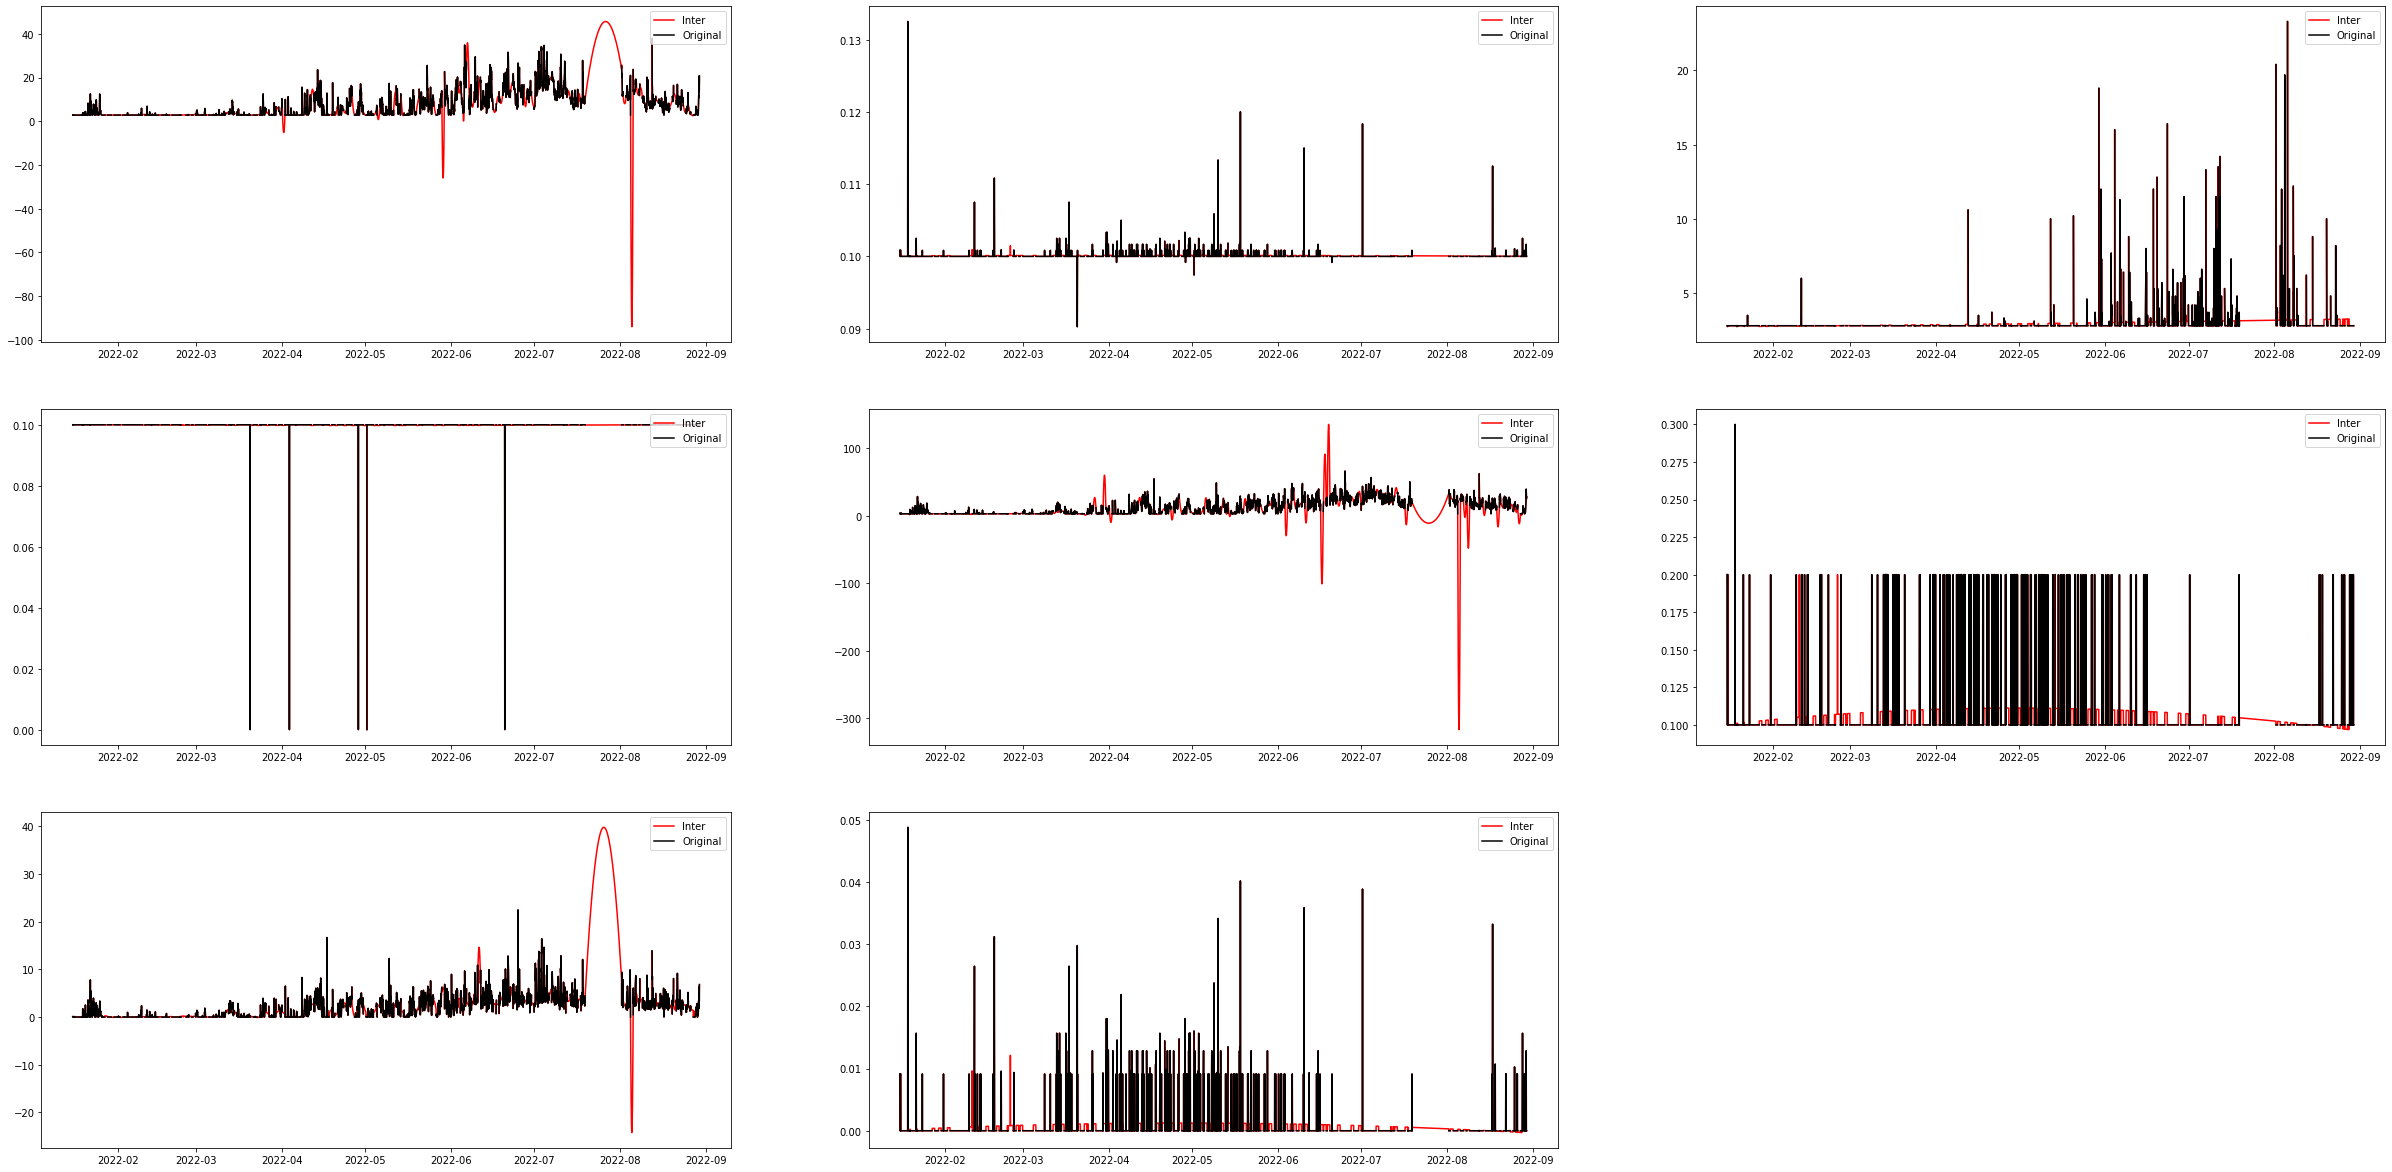

In [6]:
_prep.preprocess_fn()

### 예측 - 분석용 데이터 생성

In [7]:
_prep.pred_anal_dat_fn()

>> 예측 - 분석용 데이터 생성[종속, 설명(시차변수) 생성]
Step1. 목표변수: 암모니아, 황화수소 단위별 max 값
Step2. 시차 변수 생성
Step3. base_time 컬럼 생성


{'pred':                base_time        predict_time  x_암모니아_mean_12  x_황화수소_mean_12  \
 0    2022-01-16 14:00:00 2022-01-17 02:00:00        2.800000        0.100000   
 1    2022-01-16 15:00:00 2022-01-17 03:00:00        2.800000        0.100000   
 2    2022-01-16 16:00:00 2022-01-17 04:00:00        2.800000        0.100000   
 3    2022-01-16 17:00:00 2022-01-17 05:00:00        2.800000        0.100000   
 4    2022-01-16 18:00:00 2022-01-17 06:00:00        2.800000        0.100000   
 ...                  ...                 ...             ...             ...   
 5396 2022-08-29 10:00:00 2022-08-29 22:00:00       14.592500        0.100000   
 5397 2022-08-29 11:00:00 2022-08-29 23:00:00       20.642500        0.101667   
 5398 2022-08-29 12:00:00 2022-08-30 00:00:00       13.365833        0.100000   
 5399 2022-08-29 13:00:00 2022-08-30 01:00:00       14.245833        0.100000   
 5400 2022-08-29 14:00:00 2022-08-30 02:00:00       20.650000        0.100000   
 
       x_암모니아_min_

### 예측 하기

In [8]:
final_result = []
for y_name in ['y_암모니아','y_황화수소']:
    print(f'Model Train Date : {working_date} / Y Name : {y_name}')
    _pred = pred.pred(working_date, y_name, model_path, _prep.pred_anal_dat)
    predict_result = _pred.pred_ret.copy()
    predict_result['y_name'] = y_name
    final_result.append(predict_result)
final_result = pd.concat(final_result, ignore_index=True)
final_result = final_result[['base_time','predict_time','pred_val','y_name']]
final_result

Model Train Date : 20220926 / Y Name : y_암모니아
Working Date : 20220926 / Y Name : y_암모니아 / BEST MODEL is LSTM
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
169/169 [==============================] - 1s 2ms/step
Model Train Date : 20220926 / Y Name : y_황화수소
Working Date : 20220926 / Y Name : y_황화수소 / BEST MODEL is ARIMA


,base_time,predict_time,pred_val,y_name
0,2022-01-16 14:00:00,2022-01-17 02:00:00,NaN,y_암모니아
1,2022-01-16 15:00:00,2022-01-17 03:00:00,NaN,y_암모니아
2,2022-01-16 16:00:00,2022-01-17 04:00:00,NaN,y_암모니아
3,2022-01-16 17:00:00,2022-01-17 05:00:00,NaN,y_암모니아
4,2022-01-16 18:00:00,2022-01-17 06:00:00,3.258590,y_암모니아
...,...,...,...,...
10797,2022-08-29 10:00:00,2022-08-29 22:00:00,0.098876,y_황화수소
10798,2022-08-29 11:00:00,2022-08-29 23:00:00,0.101027,y_황화수소
10799,2022-08-29 12:00:00,2022-08-30 00:00:00,0.100683,y_황화수소
10800,2022-08-29 13:00:00,2022-08-30 01:00:00,0.100919,y_황화수소
